In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from NEID_solar_functions import *
# from GP_kernels import *

from astropy.timeseries import LombScargle
from datetime import timedelta, date
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.signal import hilbert, chirp


#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('./data_v4/v_grid.txt')
CCF     = np.loadtxt('./data_v4/CCF.txt')
σCCF   = np.loadtxt('./data_v4/σCCF.txt')
bjd     = np.loadtxt('./data_v4/bjd.txt')
rv      = np.loadtxt('./data_v4/rv.txt')
σrv     = np.loadtxt('./data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('idx_rej'), dtype=bool)

In [2]:
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

In [40]:
from scipy import stats

def moving_ave(t, y, width=2):
    w_aves = []
    for t_i in t:
        weights = stats.norm.pdf(t, t_i, width)
        # weights = np.multiply(abs(array_x-t_i)<width, 1) 
        w_ave, _ = weighted_avg_and_std(y, weights)
        w_aves.append(w_ave)
        # w_stds.append(w_std)
    return np.array(w_aves)


def ts_statistics(t, y, yerr, title, Delta_t_max, width=0.2, simple_plot=True):
    from statsmodels.nonparametric.kernel_regression import KernelReg

    
    gp = GP_fit_p1(t, y, yerr, p=5.2)
    # gp = GP_fit_Matern52Kernel(x=t, yerr=yerr, r=1)
    
    if simple_plot == False:
        fig = plt.figure(figsize=(15, 18))
        plt.subplots_adjust(right=0.85, hspace=0.5)
    else:
        fig = plt.figure(figsize=(15, 12))
        plt.subplots_adjust(right=0.85, hspace=0.3)
        
    plt.rcParams.update({'font.size': 12})

    # Fig 1 - data time series 
    if simple_plot == False:
        plt.subplot(611)
    else:
        plt.subplot(311)
    plt.title(title)
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    x = np.linspace(min(t), max(t), 10*len(t))
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)        
    plt.plot(x, pred_mean, color='r', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='r', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("T [minutes]")
    plt.ylabel("RV [m/s]")
    plt.grid()

    
    # Fig 2 - Covariance 
    if simple_plot == False:
        plt.subplot(612)
    else:
        plt.subplot(312)
    Delta_t = np.linspace(0, Delta_t_max, 5*len(t[t<Delta_t_max]))
    cov_XY = []
    for delta_t in Delta_t:
        X = y[t<(max(t)-delta_t)]
        Y, _ = gp.predict(y, t[t<(max(t)-delta_t)]+delta_t, return_var=False)
        cov_XY.append(cov(X, Y))
    cov_XY = np.array(cov_XY)
    analytic_signal = hilbert(cov_XY)
    amplitude_envelope = np.abs(analytic_signal)
    amplitude_envelope = moving_ave(Delta_t, amplitude_envelope, width=2)
    # kr = KernelReg(amplitude_envelope, Delta_t, 'c')
    # ae_pred, ae_std = kr.fit(Delta_t)
    plt.plot(Delta_t, cov_XY, 'k.-', alpha=0.5)
    plt.plot(Delta_t, amplitude_envelope, 'm', lw=5, alpha=0.4)
    plt.plot(Delta_t, -amplitude_envelope, 'm', lw=5, alpha=0.4)        
    plt.xlabel(r'$\Delta$T [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    if max(Delta_t)>250:
        plt.xlim([0,250])
    plt.grid()
    
    if simple_plot ==True:
        plt.subplot(313)
        plt.plot(Delta_t, cov_XY, 'k.-', alpha=0.5)
        plt.plot(Delta_t, amplitude_envelope, 'm', lw=5, alpha=0.4)
        plt.plot(Delta_t, -amplitude_envelope, 'm', lw=5, alpha=0.4)        
        plt.xlabel(r'$\Delta$T [minutes]')
        plt.ylabel(r'Covariance [m$^2$/s$^2$]') 
        plt.xlim([0,32])
        plt.grid()

    if simple_plot == False:
        # Fig 3 - Correlation statistics
        plt.subplot(613)
        spacing, diff = corr(t, y)
        plt.plot(spacing, diff, 'k.', alpha=0.1)        
        plt.xlabel(r'$\Delta$T [minutes]')
        plt.ylabel(r'$\Delta$RV [m/s]')


        # Fig 4 - std
        plt.subplot(614)
        w_ave, w_std = moving_std(x, spacing, diff, width)
        plt.plot(x[w_std>0.1], w_std[w_std>0.1], 'r.', alpha=0.5)
        plt.xlabel(r'$\Delta$T [minutes]')
        plt.ylabel('std [m/s]')
        # plt.plot(spacing, w_ave, 'b.', alpha=0.5)


        # Fig. 5 - Zoom in 
        plt.subplot(615)
        plt.title('zoom in')
        plt.plot(spacing, diff, 'k.', alpha=0.1)
        plt.plot(x[w_std>0.1], w_std[w_std>0.1], 'r.')
        plt.xlabel(r'$\Delta$T [minutes]')
        plt.ylabel('std [m/s]')
        plt.xlim(20, 50)


        # Fig. 6 Periodogram
        from astropy.timeseries import LombScargle
        plt.subplot(616)
        frequency, power1 = LombScargle(x[w_std>0.1], w_std[w_std>0.1]).autopower(minimum_frequency=1/(t[-1]-t[0]), maximum_frequency=1, samples_per_peak=10)        
        plt.plot(1/frequency, power1, 'r', alpha=0.5, label='corr std')
        frequency, power2 = LombScargle(t, y).autopower(minimum_frequency=1/(t[-1]-t[0]), maximum_frequency=1, samples_per_peak=10)
        plt.plot(1/frequency, power2, 'k', alpha=0.5, label='time series')
        plt.ylabel('Power')
        plt.xlabel('Period [minutes]')
        plt.legend()
        plt.xscale('log')
        plt.ylim([0, max(max(power1), max(power2))*1.1])
    
    plt.savefig('./NEID_cov/'+title+'.png')
    plt.show()
    
    return Delta_t, amplitude_envelope

# Test case: y = sin(x)

In [27]:
# start_date = datetime(2021, 5, 28)
# end_date = datetime(2021, 5, 28)

# T1 = pyasl.jdcnv(start_date)
# T2 = pyasl.jdcnv(end_date)
# idx_bjd = (bjd>=T1) & (bjd<=T2+1) & (~idx_rej)

t = np.linspace(0, 20*np.pi, 100)
# t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = np.sin(t)
yerr = np.ones(len(t))*0.05

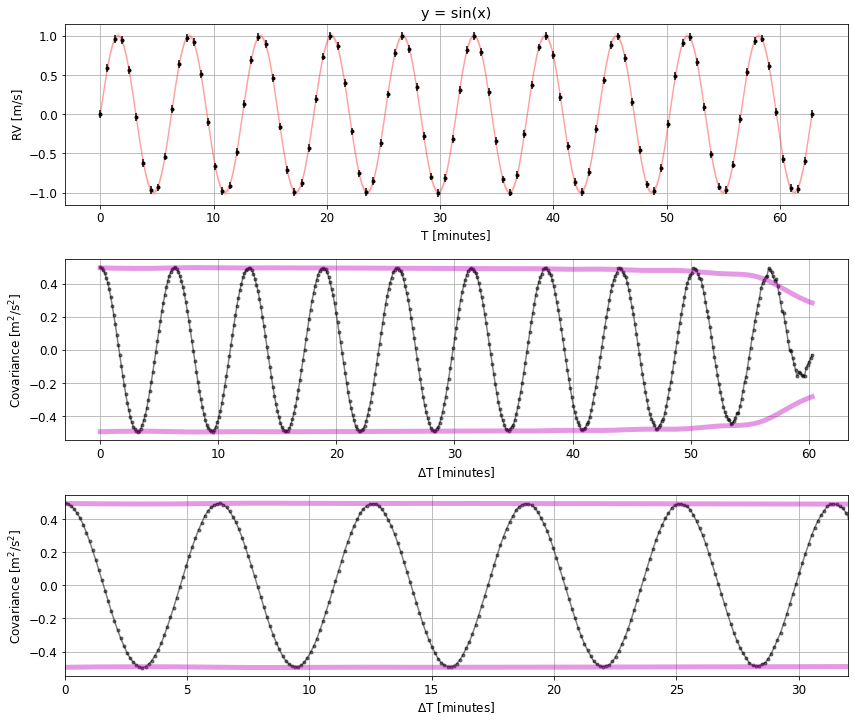

In [28]:
Delta_t, amplitude_envelope = ts_statistics(t, y, yerr, Delta_t_max=t[-5], width=0.18, title='y = sin(x)')

# NEID Solar RV 

In [41]:
start_date = datetime(2021, 5, 28)
end_date = start_date
# end_date = datetime(2021, 5, 29)

T1 = pyasl.jdcnv(start_date)
T2 = pyasl.jdcnv(end_date)
idx_bjd = (bjd>=T1) & (bjd<=T2+1) & (~idx_rej)


t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]    

print(t.shape)

(200,)


In [1]:
delta_t = 10
t_plot = np.linspace(min(t), max(t), 500)
gp = GP_fit_p1(t, y, yerr, p=5.2)
y_plot, _ = gp.predict(y, t_plot, return_var=False)
X = y[t<=(max(t)-delta_t)]
Y, _ = gp.predict(y, t[t<(max(t)-delta_t)]+delta_t, return_var=False)
fig = plt.figure(figsize=(18, 4))
plt.title(r'$\Delta T = 10$ min')
plt.plot(t_plot, y_plot, 'k', alpha=0.5)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t[t<(max(t)-delta_t)], X, 'ro', label=r'RV($t_i$)')
plt.plot(t[t<(max(t)-delta_t)]+delta_t, Y, 'bo', label=r'RV($t_i+\Delta T$)')
plt.legend()
plt.xlabel("T [minutes]")
plt.ylabel("RV [m/s]")
plt.grid()
plt.show()

delta_t = max(t)-10
t_plot = np.linspace(min(t), max(t), 500)
gp = GP_fit_p1(t, y, yerr, p=5.2)
y_plot, _ = gp.predict(y, t_plot, return_var=False)
X = y[t<=(max(t)-delta_t)]
Y, _ = gp.predict(y, t[t<(max(t)-delta_t)]+delta_t, return_var=False)
fig = plt.figure(figsize=(18, 4))
plt.title(r'$\Delta T = T_{max}-10$ min')
plt.plot(t_plot, y_plot, 'k', alpha=0.5)
plt.errorbar(t, y, yerr=yerr, fmt=".r", capsize=0)
plt.plot(t[t<(max(t)-delta_t)], X, 'ro', label=r'RV($t_i$)')
plt.plot(t[t<(max(t)-delta_t)]+delta_t, Y, 'bo', label=r'RV($t_i+\Delta t$)')
plt.legend()
plt.xlabel("T [minutes]")
plt.ylabel("RV [m/s]")
plt.grid()
plt.show()

NameError: name 'np' is not defined

### one day's RVs

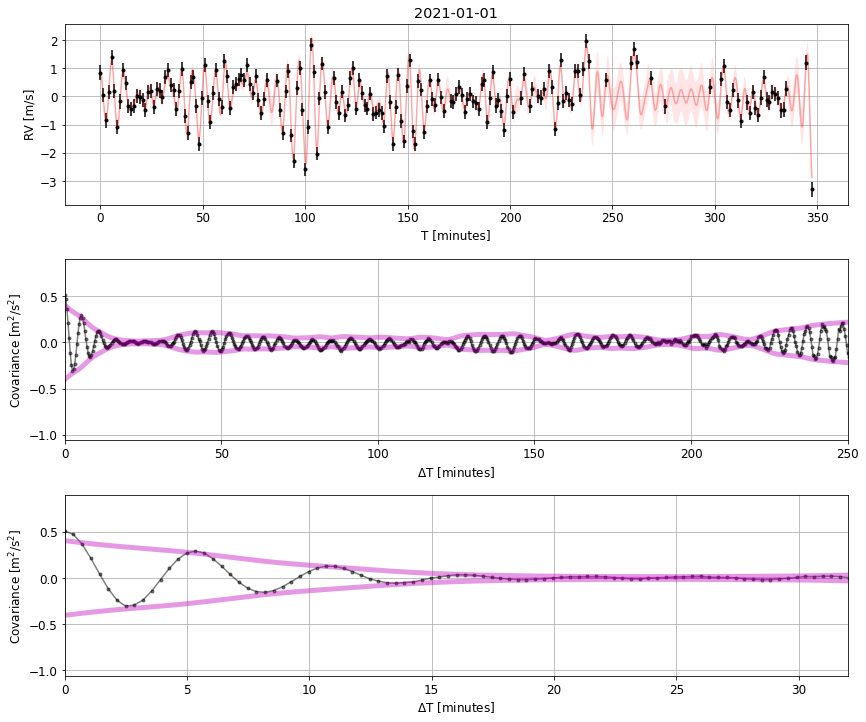

In [45]:
Delta_t, amplitude_envelope = ts_statistics(t, y, yerr, Delta_t_max=t[-2]-t[1], title=str(start_date)[:10])
# Delta_t, amplitude_envelope = ts_statistics(t, y, yerr, Delta_t_max=32, title=str(start_date)[:10])

### take out the first and last hour of RVs

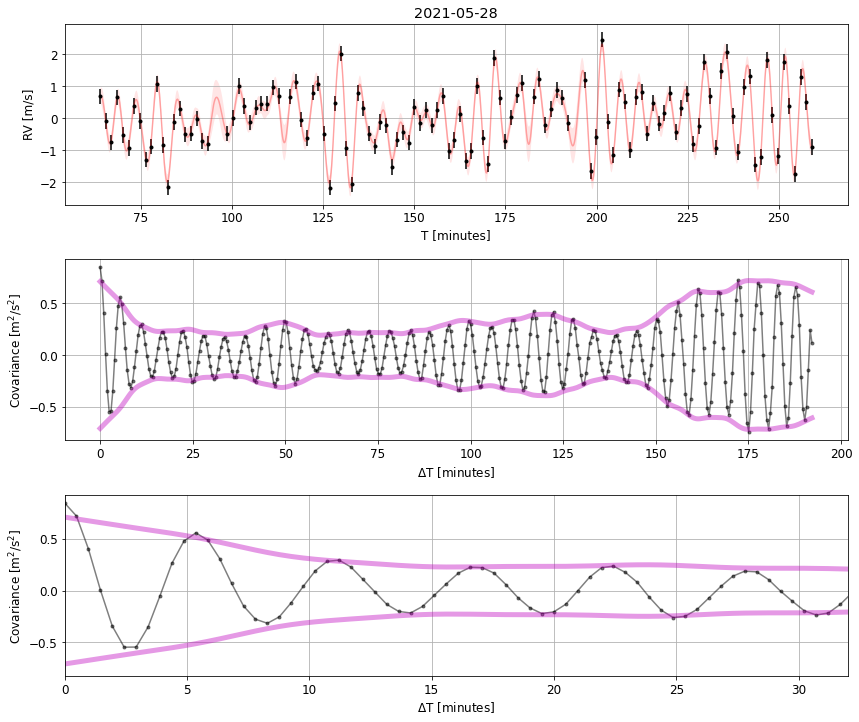

In [35]:
Delta_t, amplitude_envelope = ts_statistics(t[40:-40], y[40:-40], yerr[40:-40], Delta_t_max=t[-42]-t[41], title=str(start_date)[:10])
# ts_statistics(t[50:-50], y[50:-50], yerr[50:-50])

## Loop

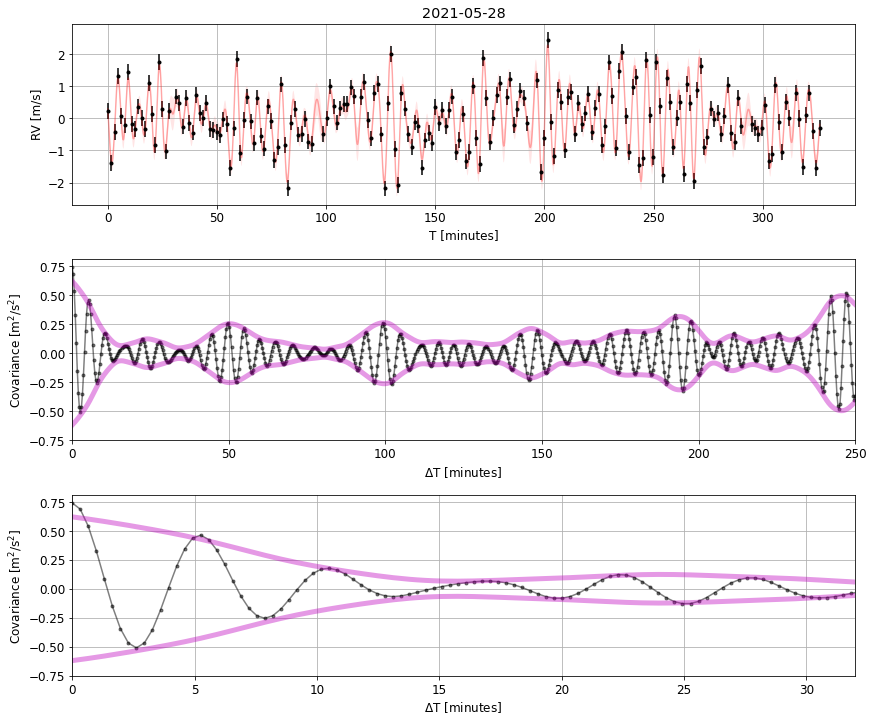

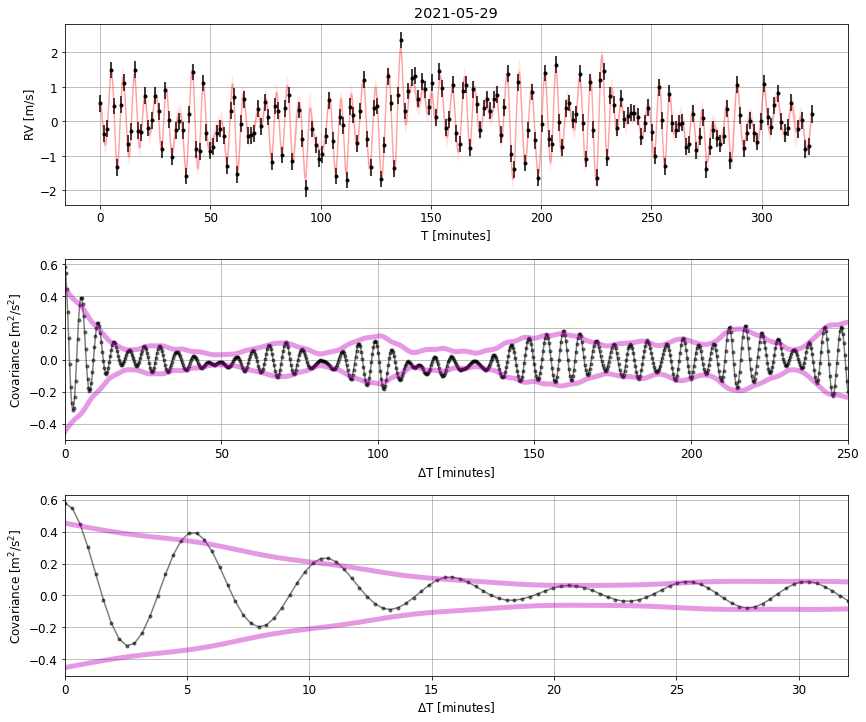

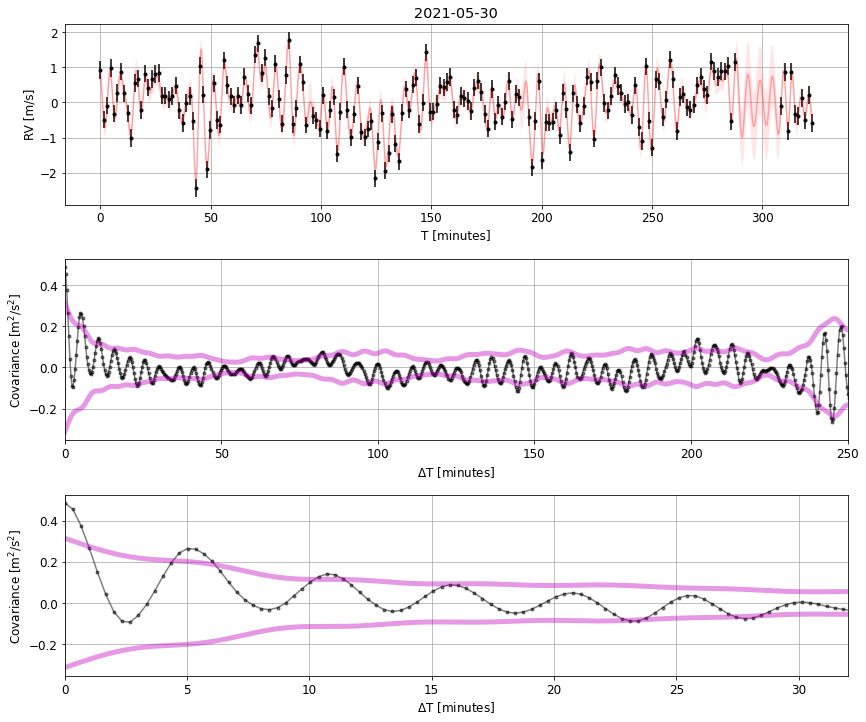

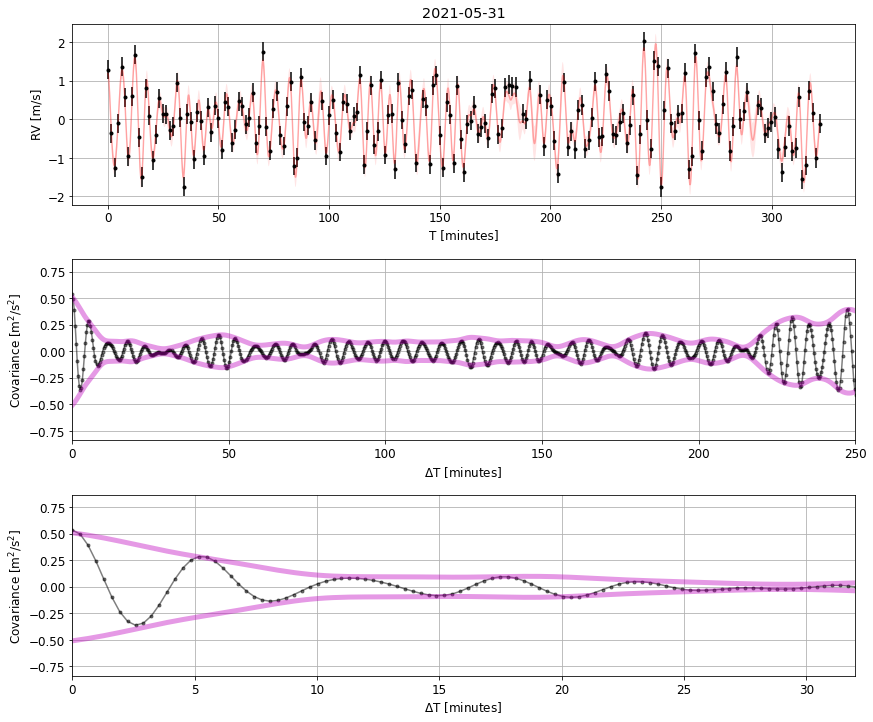

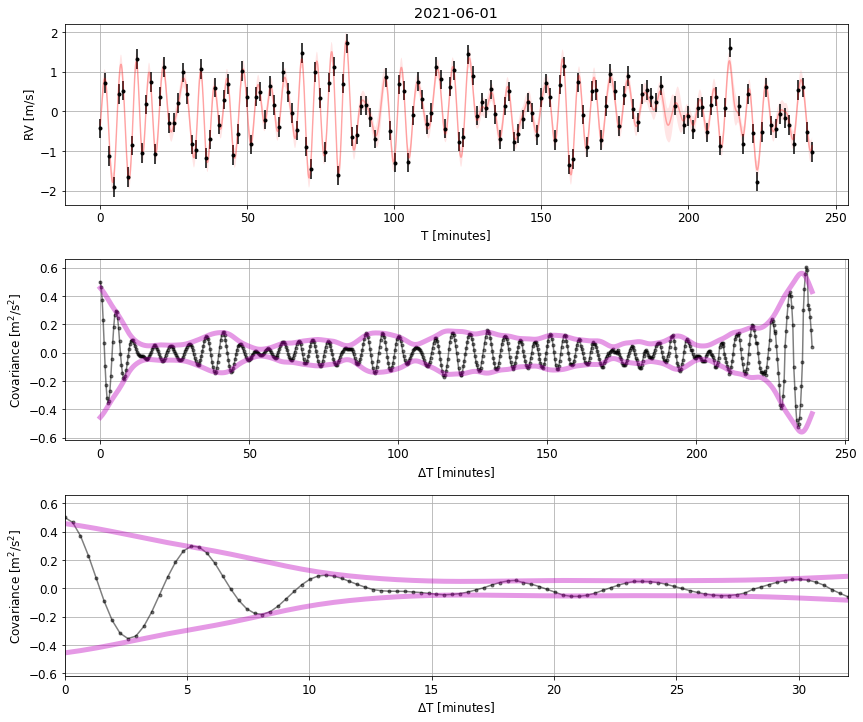

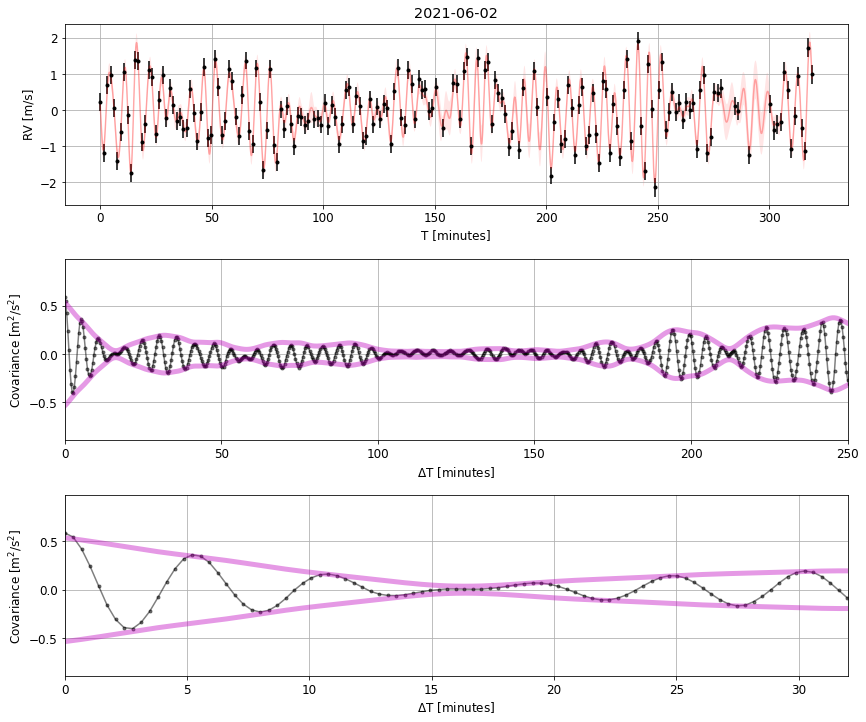

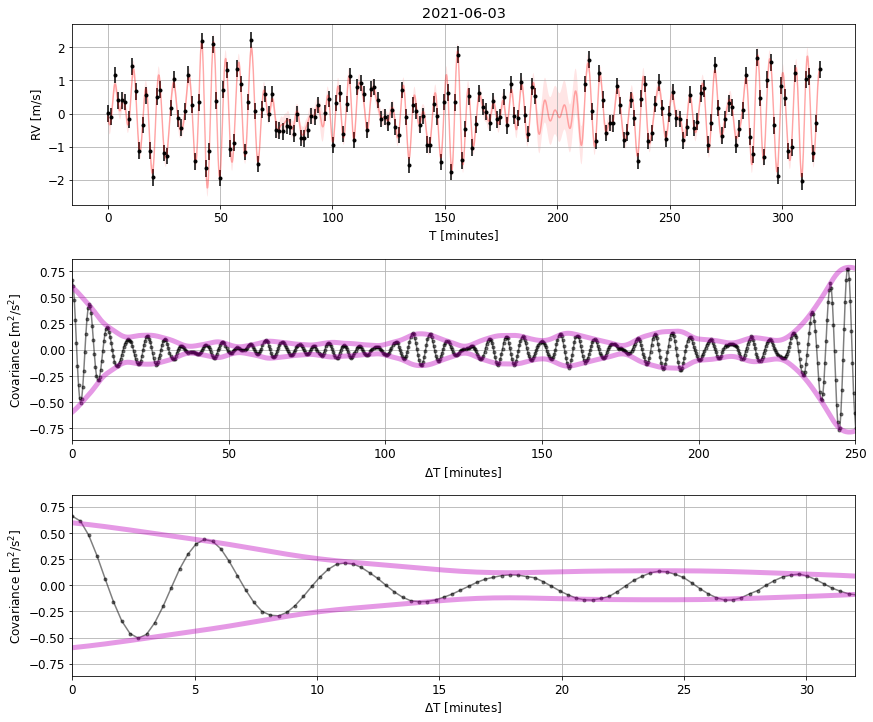

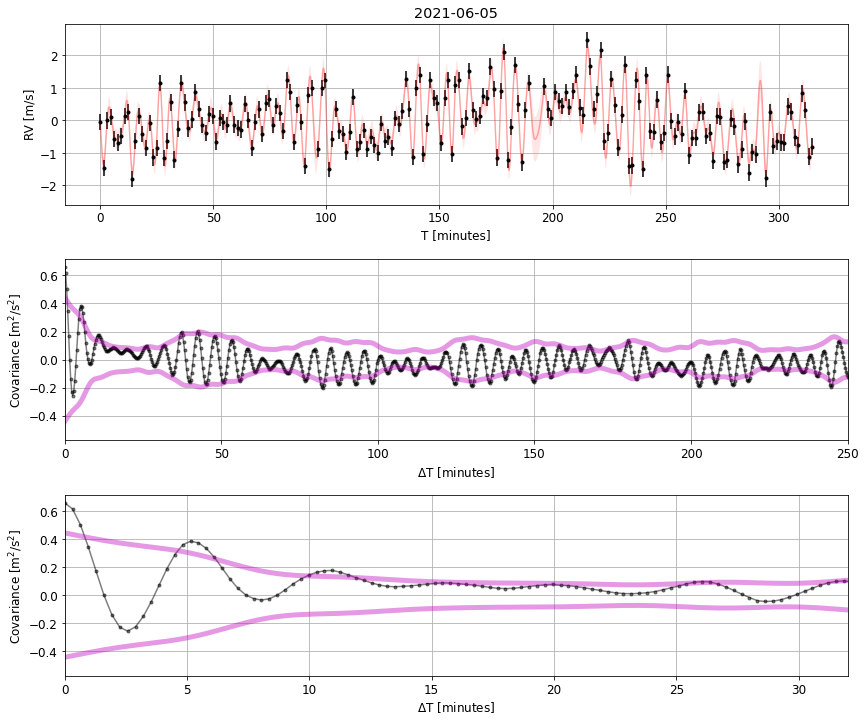

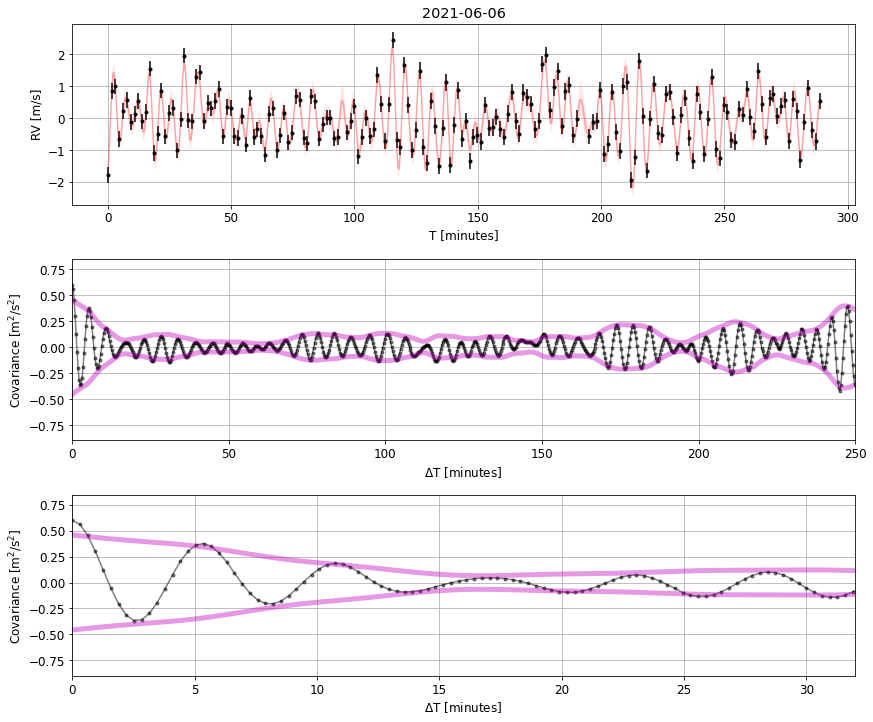

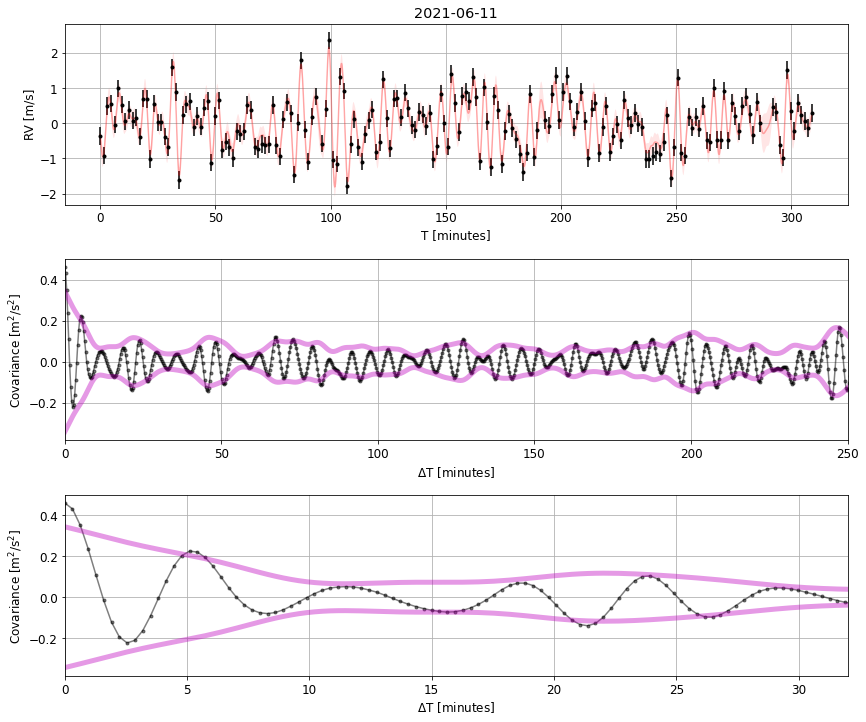

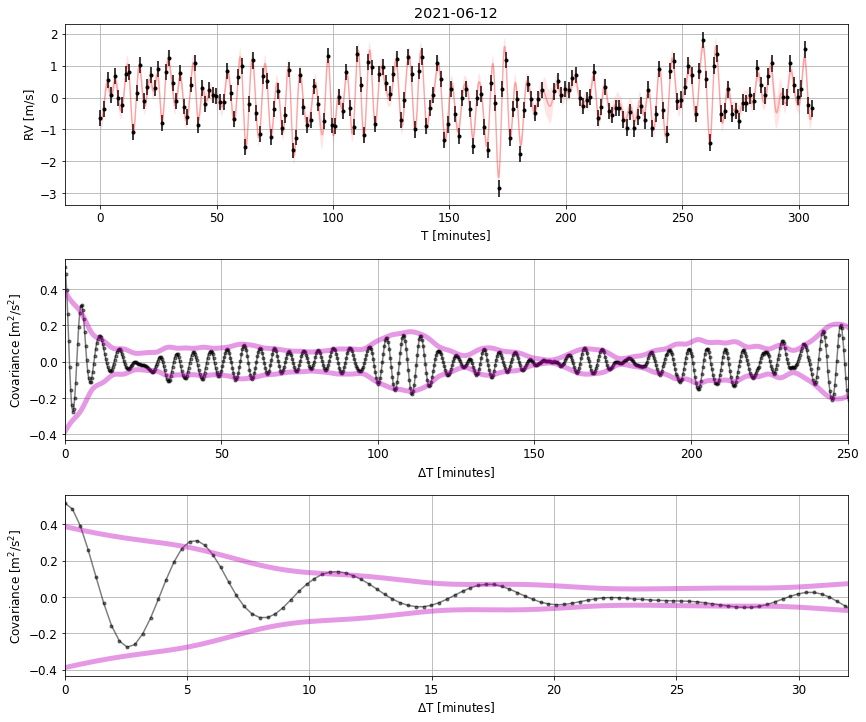

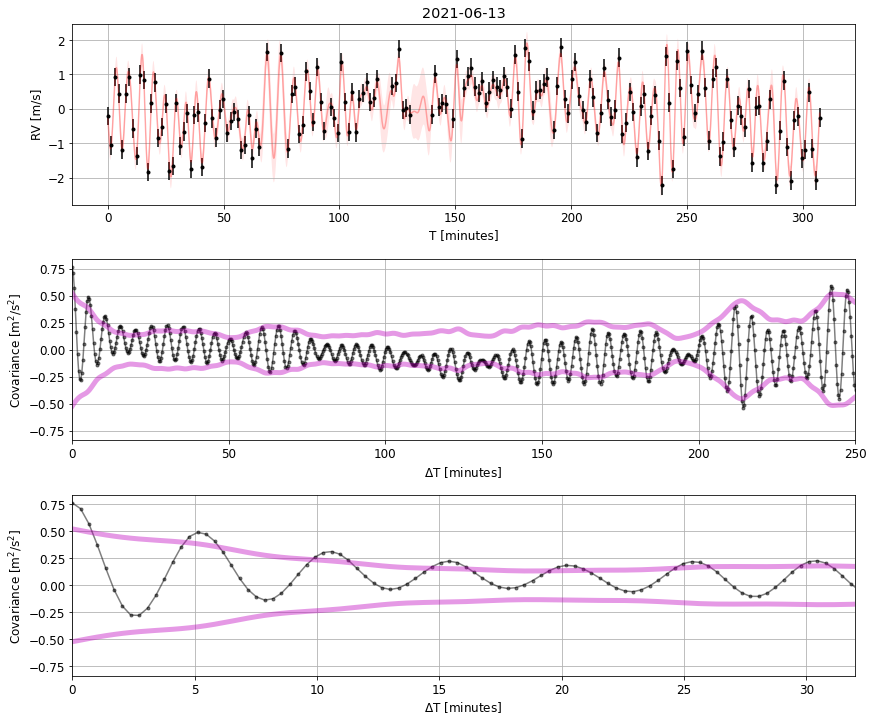

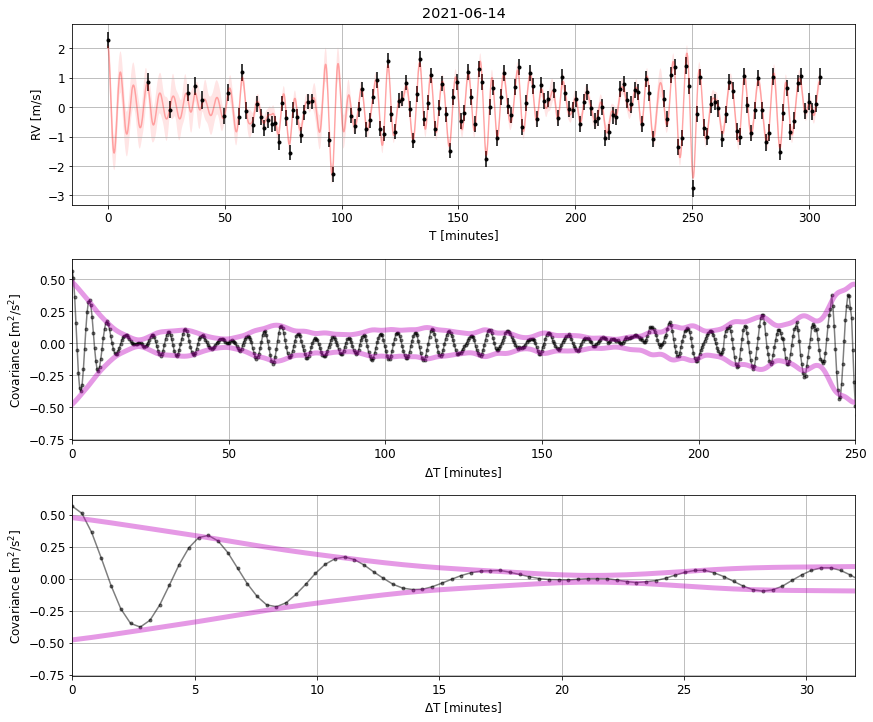

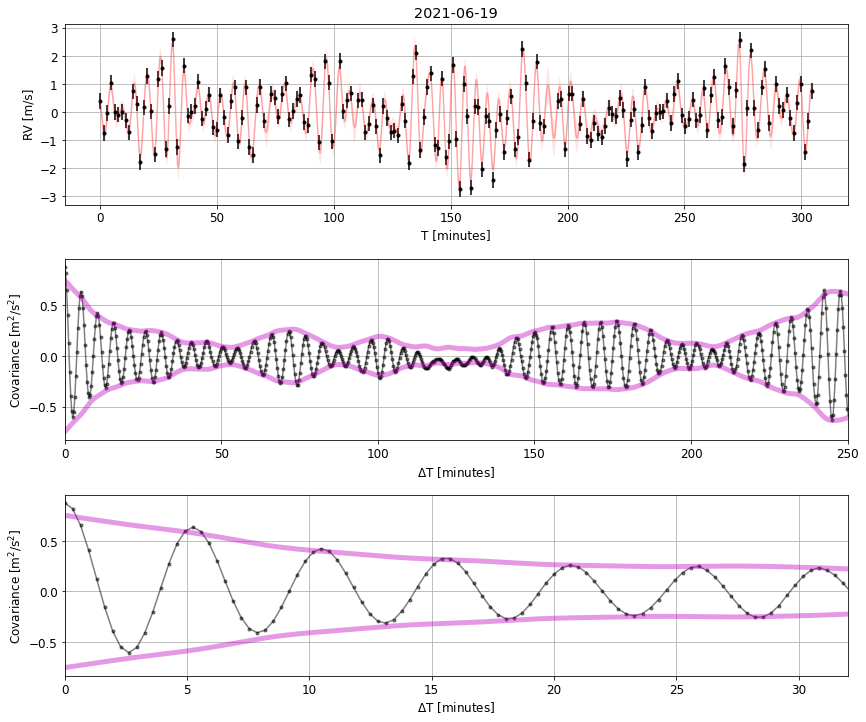

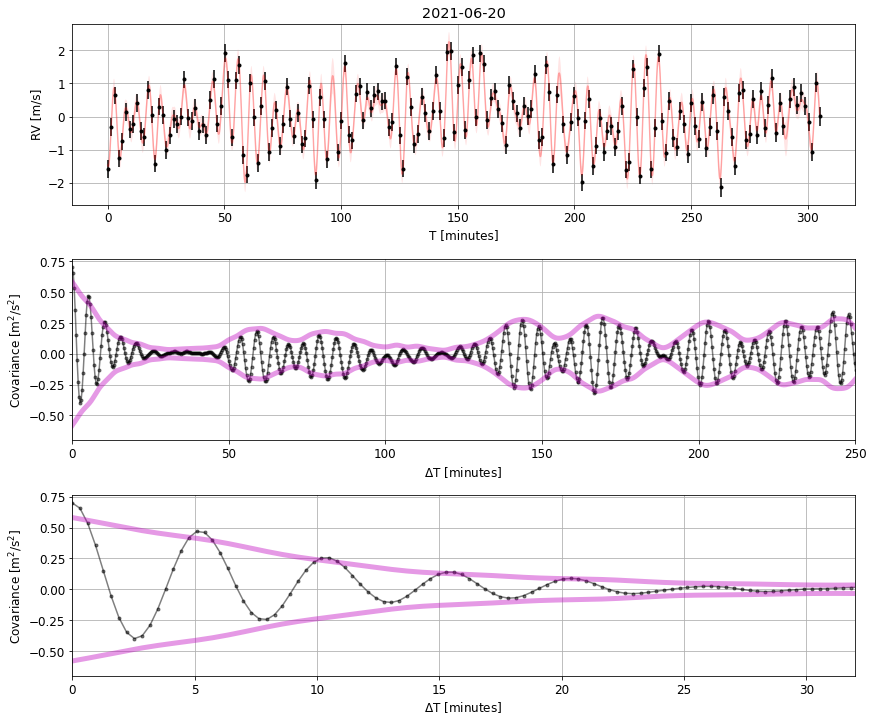

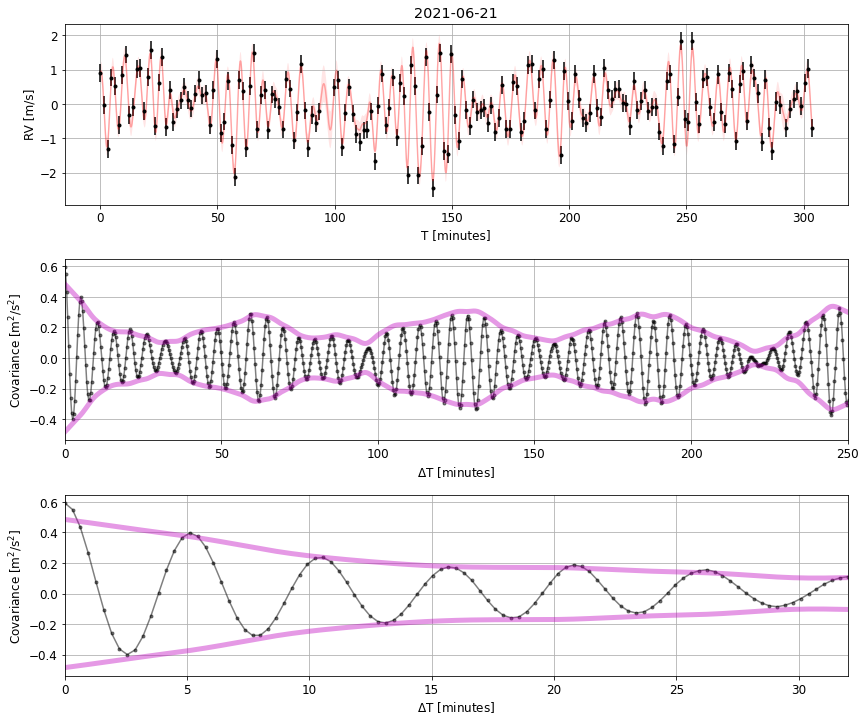

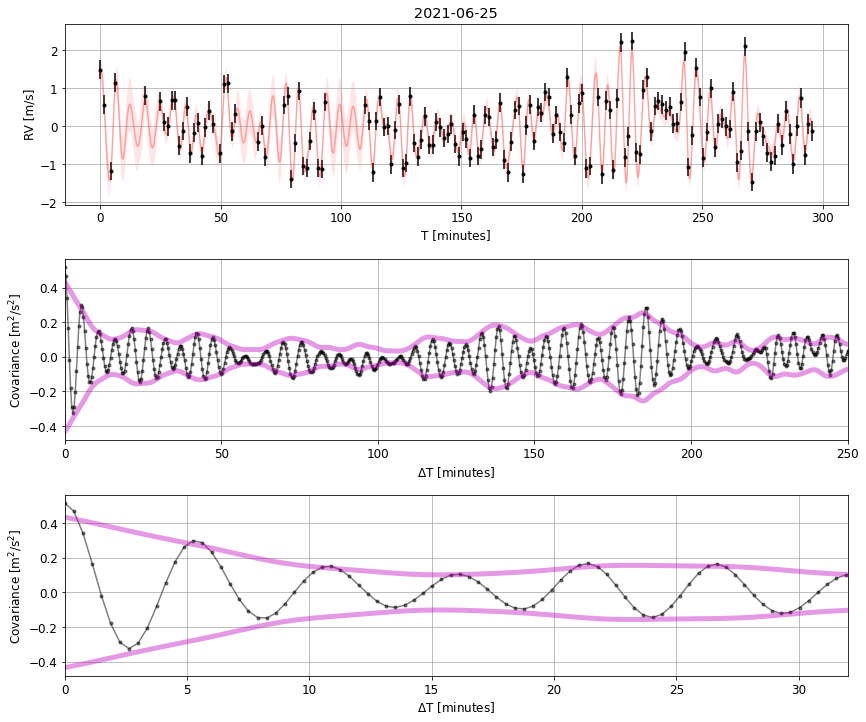

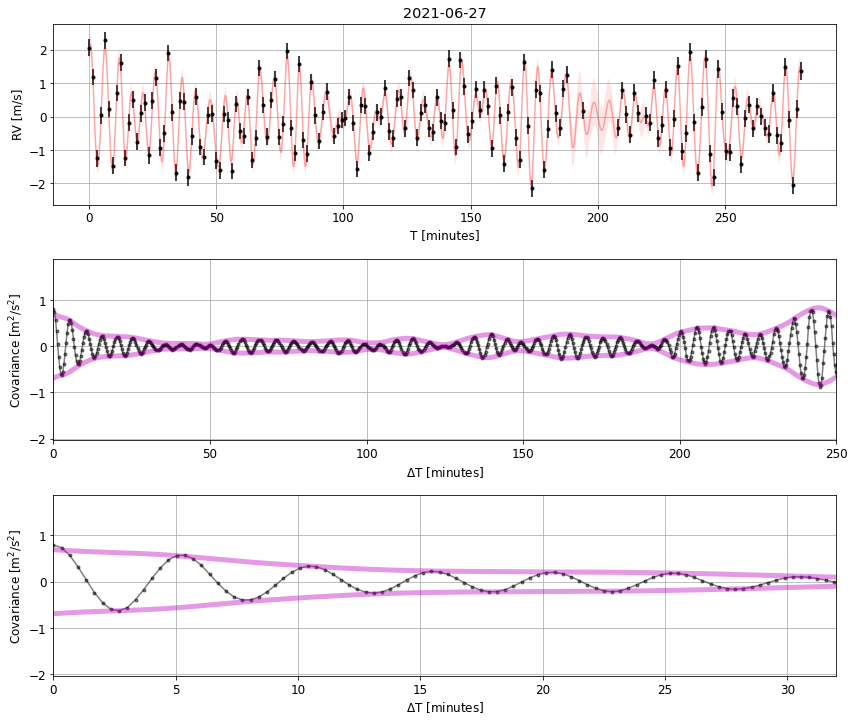

In [52]:
start_date = datetime(2021, 5, 28)
end_date = datetime(2021, 6, 30)

Delta_t = []
amplitude_envelope = []

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    
    if len(bjd[idx_bjd])>150:

        t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
        y = rv[idx_bjd] - np.mean(rv[idx_bjd])
        reg = LinearRegression().fit(t.reshape((-1, 1)), y)
        y = y - reg.predict(t.reshape((-1, 1)))
        yerr = σrv[idx_bjd]
        
        dt, am = ts_statistics(t, y, yerr, Delta_t_max=t[-2]-t[1], title=str(date)[:10])
        Delta_t.append(dt)
        amplitude_envelope.append(am)
        # ts_statistics(t[40:-40], y[40:-40], yerr[40:-40], title=str(date)[:10])
        

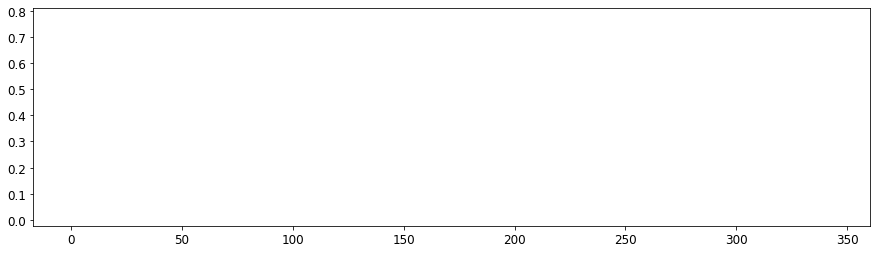

In [46]:
fig = plt.figure(figsize=(15, 4))
for k in np.arange(len(Delta_t)):
    plt.plot(Delta_t[k], amplitude_envelope[k], alpha=0.4)

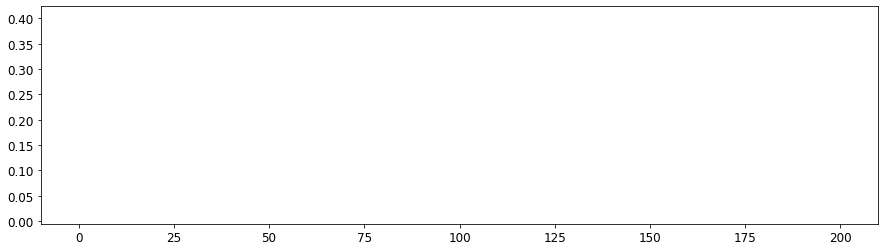

In [47]:
fig = plt.figure(figsize=(15, 4))
for k in np.arange(len(Delta_t)):
    idx = Delta_t[k]<200
    plt.plot(Delta_t[k][idx], amplitude_envelope[k][idx], alpha=0.5)

# Test 

In [16]:
X = np.arange(10)
Y = -np.arange(10)*3
cov(X, Y)

-24.75

# Generate mock data

same $t$ and $yerr$ as the observing

In [17]:

alpha=0.6
S0 = 0.12
Q = 6
for i in range(3):
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(18, 3))

    k1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)))
    gp = celerite.GP(k1)
    gp.compute(t, yerr)
    y = gp.sample()
    # plt.errorbar(t, y, yerr, fmt=".k", ms=5, label='kernel1')

    ts_statistics(t, y, yerr, title='mock data')

TypeError: ts_statistics() missing 1 required positional argument: 'Delta_t_max'

<Figure size 1296x216 with 0 Axes>